# Training
We need to create a class to grab the data, and a training script with the appropriate configurations

In [96]:
import torch
from torch import nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from IPython import display

import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from titanic_mlp.mlp import MLP

## Dataset and Preprocessing
Utilizing the `Dataset` class eases the loading our data during training and validation.

In [97]:
class TitanicDataSet(Dataset):
    def __init__(self, train, idx, dataframe, normalize_fn, retrieve_stats):
        self.data = dataframe[:idx] if train else dataframe[idx:]
        self.labels = torch.tensor(self.data['Survived'].values, dtype=torch.float32)
        if normalize_fn:
            stats = retrieve_stats(dataframe[:idx])
            self.features = normalize_fn(self.data.drop('Survived', axis=1), stats)
            self.features = torch.tensor(self.features.astype(float).values, dtype=torch.float32)
        else:
            self.features = torch.tensor(self.data.drop('Survived', axis=1))
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        label, feature = self.labels[idx], self.features[idx]
        return feature, label

We also need to normalize the columns `Age` and `Fare` to a mean of 0 and a std of 1 using Z-score normalization.
$$
Z = \frac{X - \mu}{\sigma}
$$

In [98]:
def normalize_data(data, stat):
    a_m, a_s, f_m, f_s = stat
    
    data['Age'] = (data['Age'] - a_m) / a_s
    
    data['Fare'] =  (data['Fare'] - f_m) / f_s
    
    return data

def retrieve_stats(data):
    return [
        data['Age'].mean(),
        data['Age'].std(),
        data['Fare'].mean(),
        data['Fare'].std()
    ]

We will need another function to process raw data during inference.

In [99]:
def process_raw_data(raw_data, stat): 
    MASTER_COLUMNS = [
    'Age', 'Fare', 'Parch', 'FamilySize', 'IsAlone_1', 
    'Pclass_2', 'Pclass_3', 'Sex_male', 
    'Deck_DE', 'Deck_FG', 'Deck_U', 
    'Embarked_Q', 'Embarked_S']

    if isinstance(raw_data, pd.Series):
        raw_data = raw_data.to_frame().T
    else:
        raw_data = raw_data.copy()
        
    raw_data = raw_data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']]
    
    # normalize raw_data with stat
    raw_data = normalize_data(raw_data, stat)
    
    # process deck
    raw_data['Deck'] = raw_data['Cabin'].str.get(0)

    raw_data['Deck'] = raw_data['Deck'].fillna('U')
    raw_data['Deck'] = raw_data['Deck'].replace('T', 'U')
    
    raw_data['Deck'] = raw_data['Deck'].replace(['A', 'T'], 'ABC')
    raw_data['Deck'] = raw_data['Deck'].replace(['B', 'C'], 'ABC')
    raw_data['Deck'] = raw_data['Deck'].replace(['D', 'E'], 'DE')
    raw_data['Deck'] = raw_data['Deck'].replace(['F', 'G'], 'FG')


    del raw_data['Cabin']
    
    # process FamilySize and isAlone
    raw_data['FamilySize'] = raw_data['SibSp'] + raw_data['Parch'] + 1 
    raw_data['IsAlone'] = (raw_data['FamilySize'] == 1).astype(int)
    
    del raw_data['SibSp']
    
    # Convert categorical to dummies
    df_dummies = pd.get_dummies(raw_data, columns=['IsAlone', 'Pclass', 'Sex', 'Deck', 'Embarked'], drop_first=True)
    
    df_processed = df_dummies.reindex(columns=MASTER_COLUMNS, fill_value=0)
    
    # Return as a PyTorch Tensor
    return torch.tensor(df_processed.values.astype('float32'))

# Training Loop
We will use SGD as our optimization function, our loss function MSE, a scheduler to reduce the learning rate, and initialize our weights with Xavier Uniform. Our epochs will be `40`, learning rate `0.001`, and batch size of 32. Below lies our training loop script

Final Training Loss: 0.4381
Final Validation Loss: 0.4297


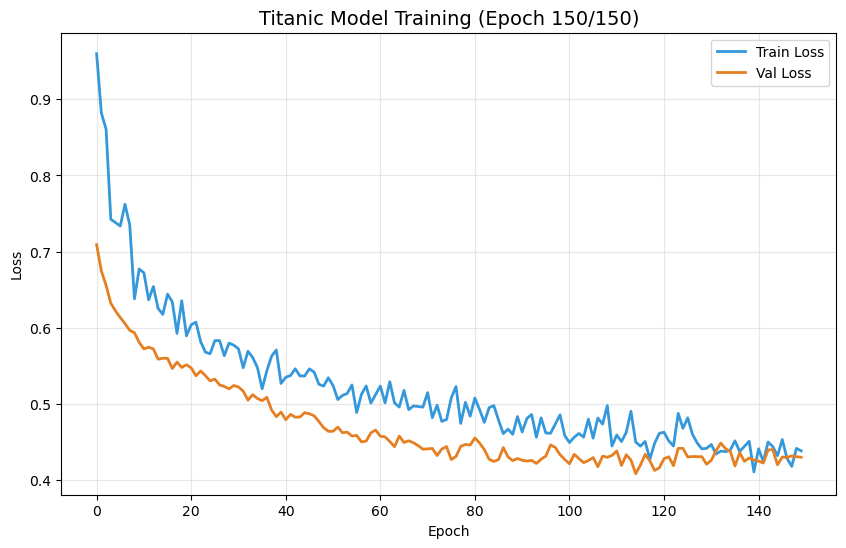

In [ ]:
# set hyperparameters
epochs = 150
lr = 0.001
batch_size = 32

# create model
model = MLP()

# dry run the model with a feature of 13
model(torch.zeros((32, 13)))

# create optimizer, scheduler and loss function
optim = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min', patience=30)
loss_fn = nn.BCEWithLogitsLoss()


@torch.no_grad()
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# Apply it to the whole model
model.apply(init_weights)
        
# load data
df = pd.read_csv('../data/titanic_processed.csv', index_col=0)
        
# initialize training_set and validation_set
training_set = TitanicDataSet(train=True, idx=600, dataframe=df, 
                              normalize_fn=normalize_data, retrieve_stats=retrieve_stats)
validation_set = TitanicDataSet(train=False, idx=600, dataframe=df, 
                              normalize_fn=normalize_data, retrieve_stats=retrieve_stats)

# initialize dataloaders
training_loader = DataLoader(training_set, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=32, shuffle=False)
# Setup the figure
plt.ion() 
fig, ax = plt.subplots(figsize=(10, 6))
train_losses = []
val_losses = []

for epoch in range(epochs):
    # --- TRAINING PHASE ---
    model.train() # Set model to training mode
    running_train_loss = 0.0
    for inputs, labels in training_loader:
        optim.zero_grad()
        outputs = model(inputs)
        # Squeeze/Unsqueeze if necessary to match shapes
        loss = loss_fn(outputs, labels.unsqueeze(1).float()) 
        loss.backward()
        optim.step()
        running_train_loss += loss.item()
    
    avg_train_loss = running_train_loss / len(training_loader)
    train_losses.append(avg_train_loss)

    # --- VALIDATION PHASE ---
    model.eval() # Set model to evaluation mode (turns off dropout/batchnorm)
    running_val_loss = 0.0
    with torch.no_grad(): # No gradients needed for validation
        for v_inputs, v_labels in validation_loader:
            v_outputs = model(v_inputs)
            v_loss = loss_fn(v_outputs, v_labels.unsqueeze(1).float())
            running_val_loss += v_loss.item()
            
    avg_val_loss = running_val_loss / len(validation_loader)
    val_losses.append(avg_val_loss)
    
    scheduler.step(avg_val_loss)

    # --- FANCY LIVE PLOT ---
    ax.clear()
    ax.plot(train_losses, label='Train Loss', color='#3498db', linewidth=2)
    ax.plot(val_losses, label='Val Loss', color='#e67e22', linewidth=2)
    
    # Aesthetics
    ax.set_title(f'Titanic Model Training (Epoch {epoch+1}/{epochs})', fontsize=14)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    display.display(plt.gcf())
    display.clear_output(wait=True)

plt.ioff()
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")

Our final validation accuracy is ~60%, which is impressive considering it's my first time doing this. Let us save the model, then evaluate the test dataset and submit it on Kaggle.

In [169]:
# save model
torch.save(model.state_dict(), '../models/titanic_mlp_v1.pth')

model.eval()

# load test.csv
test_data = pd.read_csv('../data/test.csv', index_col=[0])


# get stat from old data
stats = retrieve_stats(df[:600])
test_inputs = process_raw_data(test_data, stats)


with torch.no_grad():
    logits = model(test_inputs)
    # Use Sigmoid to get probability, then round to get 0 or 1
    probabilities = torch.sigmoid(logits)
    predictions = (probabilities > 0.5).int().flatten().tolist()
    
answers = pd.DataFrame({
    'PassengerId': test_data.index, 
    'Survived': predictions
})

print(answers.head())

answers.to_csv('../data/submission.csv', index=False)

   PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1
